In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
import sys
import os

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)

from src.data.data_loader import load_data

data_path = "../dataset/spam.csv"
df = load_data(data_path)

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## General Info

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   v1          5572 non-null   str  
 1   v2          5572 non-null   str  
 2   Unnamed: 2  50 non-null     str  
 3   Unnamed: 3  12 non-null     str  
 4   Unnamed: 4  6 non-null      str  
dtypes: str(5)
memory usage: 217.8 KB


## Missing Values

Will delete the third to fifth columns due to the csv format

In [5]:
df = df[['v1', 'v2']]

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.isna().sum()

v1    0
v2    0
dtype: int64

## Duplicate Data

In [8]:
df.duplicated().sum()

np.int64(403)

In [9]:
df[df.duplicated()]

,v1,v2
102,ham,As per your request 'Melle Melle (Oru Minnamin...
153,ham,As per your request 'Melle Melle (Oru Minnamin...
206,ham,"As I entered my cabin my PA said, '' Happy B'd..."
222,ham,"Sorry, I'll call later"
325,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [10]:
df.drop_duplicates()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Analysis Target

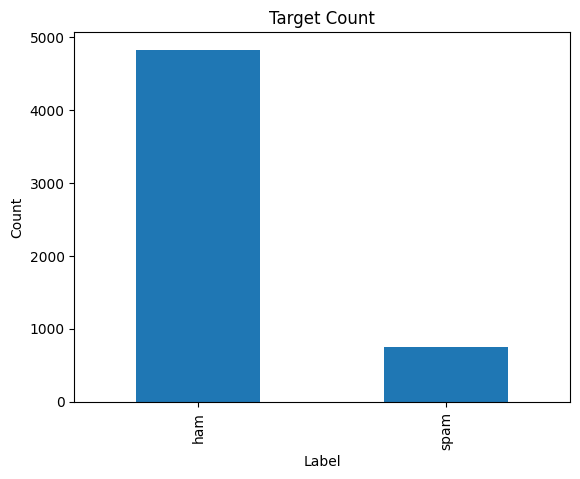

In [11]:
df['v1'].value_counts().plot(kind='bar')

plt.title('Target Count')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [12]:
pct_count = (df['v1'].value_counts()/len(df))*100
print(pct_count)

v1
ham     86.593683
spam    13.406317
Name: count, dtype: float64


From the graph and percentages above, it can be seen that this dataset is imbalanced with 86% ham

## Text Behaviour Analysis

### Character Length

In [13]:
df['char_count'] = df['v2'].apply(len)

In [14]:
df.groupby('v1')['char_count'].mean()

v1
ham      71.023627
spam    138.866131
Name: char_count, dtype: float64

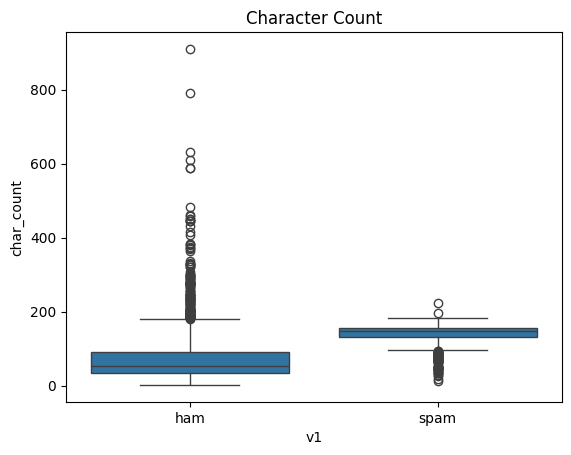

In [15]:
import seaborn as sns

sns.boxplot(x='v1', y='char_count', data=df)
plt.title('Character Count')
plt.show()

### Word Count

In [16]:
df['word_count'] =  df['v2'].apply(lambda x: len(x.split()))

In [17]:
df.groupby('v1')['word_count'].mean()

v1
ham     14.200622
spam    23.851406
Name: word_count, dtype: float64

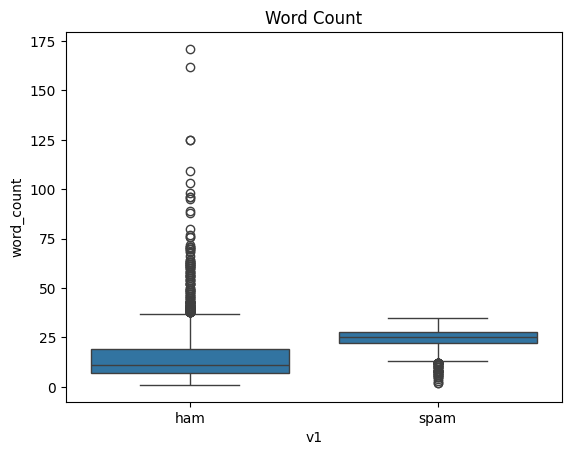

In [18]:
sns.boxplot(x='v1', y='word_count', data=df)
plt.title('Word Count')
plt.show()

### Digit Count

In [19]:
df['digit_count'] = df['v2'].apply(lambda x: sum(c.isdigit() for c in x))

In [20]:
df.groupby('v1')['digit_count'].mean()

v1
ham      0.299275
spam    15.759036
Name: digit_count, dtype: float64

### Summary

In [21]:
spam_mean = df[df['v1']=='spam'][['char_count', 'word_count', 'digit_count']].mean()

ham_mean = df[df['v1']=='ham'][['char_count', 'word_count', 'digit_count']].mean()

comparison = pd.DataFrame({
    'ham': ham_mean,
    'spam': spam_mean,
    'difference': spam_mean-ham_mean
})

comparison

,ham,spam,difference
char_count,71.023627,138.866131,67.842504
word_count,14.200622,23.851406,9.650784
digit_count,0.299275,15.759036,15.459762


Spam messages are longer and contain more numbers than non-spam messages

## Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split

x = df['v2']
y = df['v1']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# LSTM Baseline

## Data Cleaning

In [23]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [24]:
x_train_lstm = x_train.apply(clean_text)
x_test_lstm = x_test.apply(clean_text)

In [25]:
print(x_train.iloc[0])
print(x_train_lstm.iloc[0])

Going on nothing great.bye
going on nothing greatbye


## Tokenization

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

tokenizer.fit_on_texts(x_train_lstm)

In [27]:
x_train_seq = tokenizer.texts_to_sequences(x_train_lstm)
x_test_seq = tokenizer.texts_to_sequences(x_test_lstm)

In [28]:
y_train = y_train.map({'ham':0, 'spam':1})
y_test = y_test.map({'ham':0, 'spam':1})

## Padding

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 100

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')

## LSTM Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\winon\Documents\Bootcamp\ai-spam-call-detection\venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


history = model.fit(
    x_train_pad,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict
)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.6136 - loss: 0.6906 - val_accuracy: 0.1547 - val_loss: 0.7035
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5188 - loss: 0.6891 - val_accuracy: 0.1547 - val_loss: 0.7018
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5403 - loss: 0.6893 - val_accuracy: 0.8430 - val_loss: 0.6870
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.5949 - loss: 0.6892 - val_accuracy: 0.8430 - val_loss: 0.6891
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5328 - loss: 0.6889 - val_accuracy: 0.8453 - val_loss: 0.6771
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5899 - loss: 0.6893 - val_accuracy: 0.8453 - val_loss: 0.6761
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6358 - loss: 0.6891 - val_accuracy: 0.8453 - val_loss: 0.6828
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6978 - loss: 0.6890 - val_accu

In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test_pad)
y_pred_label = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_label))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



In [33]:
import numpy as np

y_probs = model.predict(x_test_pad)

print("Min:", np.min(y_probs))
print("Max:", np.max(y_probs))
print("Mean:", np.mean(y_probs))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Min: 0.4949888
Max: 0.5042045
Mean: 0.4949997
